# Create a time-dependent GRB class

### Units
- FITS GRB files
  - time [s]
  - energy [GeV]
  - spectral flux [ph/cm2/s/GeV]
- ctools grbsens outputs
  - prefactor [ph/cm2/s/MeV]
  - pivot energy [MeV]
  - emin/emax [TeV]
  - photon flux [ph/cm2/s]
  - sensitivity [erg/cm2/s]

Things to check
- Sensitivity vs. Time curves (compare photon fluxes)
- Compare power law used in each time bin
- Compare observation times of GRBs

In [21]:
import random
from pathlib import Path

import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gammapy.modeling.models import PowerLawSpectralModel
from tqdm import tqdm

from gravitational_wave_toy.ctairf import IRFHouse
from gravitational_wave_toy.observe import GRB, oGRB
from gravitational_wave_toy.sensitivity import SensitivityCtools, SensitivityGammapy
from gravitational_wave_toy.util import suppress_warnings_and_logs
from gravitational_wave_toy.logging import logger as logging

sns.set()
    
# set logging level to debug
# logging.basicConfig(level=logging.DEBUG)
logger = logging(__name__)

# Comparing sensitivities
- Prod5-v0.1 [alpha config], South, z20, 0.5h

In [22]:
# load in the IRF

house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

irf20 = house.get_irf(
    site="south",
    configuration="alpha",
    zenith=20,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1",
)

In [23]:
# load in the sensitivity files
sens_ctools = SensitivityCtools(
    "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    min_energy=30 * u.GeV,
    max_energy=10000 * u.GeV,
    mode="sensitivity"
)

sens_gamma = SensitivityGammapy(
    irf=irf20,
    observatory=f"cta_{irf20.site.name}",
    min_energy=30 * u.GeV,
    max_energy=10000 * u.GeV,
    radius=3.0 * u.deg,
)

time_bins = np.array([2**i for i in range(0, 15, 1)]) * u.s

In [24]:
# get ctools photon flux curve

ctools_unit = sens_ctools.get(t=1*u.s).unit
ctools_res = np.array([sens_ctools.get(t=t).value for t in time_bins]) * ctools_unit



In [6]:
# get gammapy photon flux curve using a constant power law
index = -2.1
amplitude = 4.415e-13 / u.cm**2 / u.s / u.MeV 
pivot = 1 * u.GeV
model = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=pivot)
# gamma_unit = sens_gamma.get(t=1*u.s, index=index, amplitude=amplitude, reference=pivot, mode="sensitivity")
gamma_res = np.array([
    # sens_gamma.get(
    #     t=t.value, index=index, amplitude=amplitude, reference=pivot, mode="sensitivity"
    # ).value for t in time_bins
    gamma_sens_old(
        irf=irf20,
        observatory=f"cta_{irf20.site.name}",
        duration=t,
        radius=3.0,
        min_energy=0.03,
        max_energy=10,
        model=model,
    ) for t in time_bins
])

UnitConversionError: '' (dimensionless) and 'deg' (angle) are not convertible

In [25]:
ctools_table = pd.read_csv(
    "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    sep="\t",
    names=[
            "obs_time",
            "crab_flux",
            "photon_flux",
            "energy_flux",
            "sensitivity",
        ],
    comment="#",
)

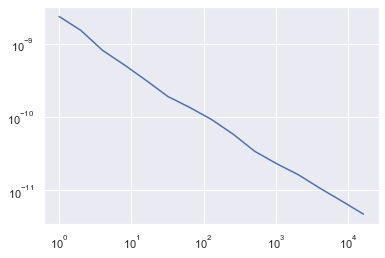

In [26]:
plt.loglog(ctools_table["obs_time"], ctools_table["photon_flux"], label="ctools")


In [48]:
sens_gamma.get(t=1*u.s, index=index, amplitude=amplitude, reference=pivot, mode="sensitivity")
sens_gamma._last_table

energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.547723,0.547723,0.03,10,1.90767e-10,7.2289,0.0188119,significance


In [56]:
ctools_res

<Quantity [7.98529365e-11, 5.14136501e-11, 3.31028956e-11, 2.13134390e-11,
           1.37227476e-11, 8.83544896e-12, 5.68874110e-12, 3.66271996e-12,
           2.35825770e-12, 1.51837417e-12, 9.77611617e-13, 6.29439365e-13,
           4.05267191e-13, 2.60932991e-13, 1.68002807e-13] erg / (s cm2)>

In [53]:
gamma_res

<Quantity [3.63920451e-20, 1.86573316e-20, 9.70870278e-21, 5.15903537e-21,
           2.81683963e-21, 1.58814253e-21, 9.26863847e-22, 5.59705592e-22,
           3.48769725e-22, 2.23358463e-22, 1.46355941e-22, 9.76963226e-23,
           6.61772337e-23, 4.53366579e-23, 3.13262134e-23] erg / (s cm2)>

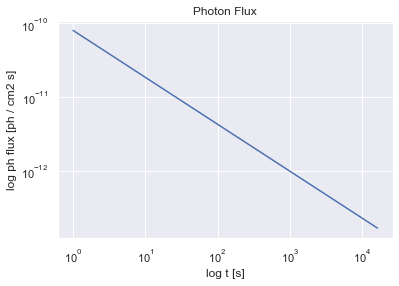

In [34]:
plt.loglog(time_bins, ctools_res*ctools_unit)
plt.xlabel("log t [s]")
plt.ylabel("log ph flux [ph / cm2 s]")
plt.title("Photon Flux")
plt.show()

<Quantity [3.63920451e-20, 1.86573316e-20, 9.70870278e-21, 5.15903537e-21,
           2.81683963e-21, 1.58814253e-21, 9.26863847e-22, 5.59705592e-22,
           3.48769725e-22, 2.23358463e-22, 1.46355941e-22, 9.76963226e-23,
           6.61772337e-23, 4.53366579e-23, 3.13262134e-23] erg / (s cm2)>

In [738]:
# cfile = "/Users/jarred/Downloads/catO5_52.fits"
# file = "/Users/jarred/Downloads/catO5_981.fits"
i = 4
file = f"/Users/jarred/Downloads/TeV Catalog O5/catO5_{i}.fits"


In [901]:
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

irf20 = house.get_irf(
    site="south",
    configuration="alpha",
    zenith=20,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1",
)

irf40 = house.get_irf(
    site="south",
    configuration="alpha",
    zenith=40,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1",
)

irf60 = house.get_irf(
    site="south",
    configuration="alpha",
    zenith=60,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1",
)

In [902]:
def get_emin(zenith: int):
    if zenith == 20:
        return 30 * u.GeV
    elif zenith == 40:
        return 40 * u.GeV
    elif zenith == 60:
        return 110 * u.GeV
    else:
        raise ValueError("Zenith must be 20, 40 or 60")

In [942]:
grb = GRB(file, min_energy=0.03*u.TeV, max_energy=100*u.TeV)
ogrb = oGRB(file, min_energy=0.03*u.TeV, max_energy=100*u.TeV)


s = SensitivityGammapy(
    irf=irf20,
    observatory=f"cta_{irf20.site.name}",
    radius=3.0 * u.deg,
    min_energy=get_emin(irf20.zenith.value),
    max_energy=10000 * u.GeV,
)

sc = SensitivityCtools(
    "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    min_energy=0.03*u.TeV,
    max_energy=10*u.TeV,
)

In [740]:
ogrb.observe(sensitivity=sc, start_time=1*u.s, )

Checking if visible from 1.0 s to 43201.0 s
False after -43200.0 s: average_flux = 5.024047343195904e-12 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_4.fits'),
 'min_energy': <Quantity 30. GeV>,
 'max_energy': <Quantity 10000. GeV>,
 'seen': False,
 'obs_time': -1,
 'start_time': <Quantity 1. s>,
 'end_time': -1,
 'error_message': '',
 'long': 3.623,
 'lat': 0.586,
 'eiso': 1.95e+49,
 'dist': 349000.0,
 'angle': 28.554,
 '_num_iters': 0,
 '_last_guess': <Quantity 43201. s>}

In [746]:
grb.observe(sc, 1600*u.s)

False after 0.0 s: average_flux = nan 1 / (s cm2) |:| photon_flux = inf 1 / (s cm2)
False after 43200.0 s: average_flux = 2.191546045746836e-12 1 / (s cm2) |:| photon_flux = 2.2911290061662873e-12 1 / (s cm2)
0.0       converged: True
           flag: 'converged'
 function_calls: 2
     iterations: 1
           root: 0.0


{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_4.fits'),
 'min_energy': <Quantity 30. GeV>,
 'max_energy': <Quantity 10000. GeV>,
 'seen': True,
 'obs_time': <Quantity -1600. s>,
 'start_time': <Quantity 1600. s>,
 'end_time': <Quantity 0. s>,
 'error_message': '',
 'long': 3.623,
 'lat': 0.586,
 'eiso': 1.95e+49,
 'dist': 349000.0,
 'angle': 28.554}

In [747]:
grb.observe(s, 1600*u.s)

False after 0.0 s: average_flux = nan 1 / (s cm2) |:| photon_flux = inf 1 / (s cm2)
True after 43200.0 s: average_flux = 2.191546045746836e-12 1 / (s cm2) |:| photon_flux = 1.0351076194443603e-13 1 / (s cm2)


True after 21600.0 s: average_flux = 3.78124216535173e-12 1 / (s cm2) |:| photon_flux = 1.4870505011505616e-13 1 / (s cm2)


True after 10800.0 s: average_flux = 6.196234161250692e-12 1 / (s cm2) |:| photon_flux = 2.1472761356989675e-13 1 / (s cm2)
True after 5400.0 s: average_flux = 9.469501808574766e-12 1 / (s cm2) |:| photon_flux = 3.134701910854122e-13 1 / (s cm2)


True after 2700.0 s: average_flux = 1.3268616971320892e-11 1 / (s cm2) |:| photon_flux = 4.606932847000337e-13 1 / (s cm2)


True after 1350.0 s: average_flux = 1.693971863361271e-11 1 / (s cm2) |:| photon_flux = 6.873018169372448e-13 1 / (s cm2)
True after 675.0 s: average_flux = 1.9790903918255936e-11 1 / (s cm2) |:| photon_flux = 1.041708537274334e-12 1 / (s cm2)


True after 337.5 s: average_flux = 2.1838181124684752e-11 1 / (s cm2) |:| photon_flux = 1.6120845031394732e-12 1 / (s cm2)


True after 168.75 s: average_flux = 2.3084202172256787e-11 1 / (s cm2) |:| photon_flux = 2.5590695247914298e-12 1 / (s cm2)


True after 84.375 s: average_flux = 2.3739760800648013e-11 1 / (s cm2) |:| photon_flux = 4.184528055818595e-12 1 / (s cm2)


True after 42.1875 s: average_flux = 2.4076415402826868e-11 1 / (s cm2) |:| photon_flux = 7.072807090499899e-12 1 / (s cm2)


True after 21.09375 s: average_flux = 2.424706463540545e-11 1 / (s cm2) |:| photon_flux = 1.2375827346763486e-11 1 / (s cm2)
True after 10.546875 s: average_flux = 2.4332983391531142e-11 1 / (s cm2) |:| photon_flux = 2.2389675899217694e-11 1 / (s cm2)


False after 5.2734375 s: average_flux = 2.4376093062976886e-11 1 / (s cm2) |:| photon_flux = 4.171153036960927e-11 1 / (s cm2)
False after 8.021666635252814 s: average_flux = 2.4353614089715974e-11 1 / (s cm2) |:| photon_flux = 2.8532922504636565e-11 1 / (s cm2)


False after 9.302455697027199 s: average_flux = 2.4343147292390398e-11 1 / (s cm2) |:| photon_flux = 2.5010025815860343e-11 1 / (s cm2)
True after 9.912566375765891 s: average_flux = 2.4338163462584992e-11 1 / (s cm2) |:| photon_flux = 2.3645172642558228e-11 1 / (s cm2)
1609.3024556970272       converged: True
           flag: 'converged'
 function_calls: 18
     iterations: 17
           root: 1609.3024556970272


{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_4.fits'),
 'min_energy': <Quantity 30. GeV>,
 'max_energy': <Quantity 10000. GeV>,
 'seen': True,
 'obs_time': <Quantity 9.3 s>,
 'start_time': <Quantity 1600. s>,
 'end_time': <Quantity 1609.3 s>,
 'error_message': '',
 'long': 3.623,
 'lat': 0.586,
 'eiso': 1.95e+49,
 'dist': 349000.0,
 'angle': 28.554}

/Users/jarred/Documents/Work/gravitational_wave_toy/.venv/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


False after 0.0 s: average_flux = nan 1 / (s cm2) |:| photon_flux = inf 1 / (s cm2)
False after -100.0 s: average_flux = 6.706646673300708e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -200.0 s: average_flux = 6.690498293862667e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -300.0 s: average_flux = 6.674386001910491e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -400.0 s: average_flux = 6.658309617695218e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -500.0 s: average_flux = 6.64226896289279e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -600.0 s: average_flux = 6.626263860588375e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -700.0 s: average_flux = 6.610294135261007e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -800.0 s: average_flux = 6.594359612768379e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -900.0 s: average_flux = 6.578460120331885e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -1000.0 s: average_flux = 6.562595486521842e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -1100.0 s: average_flux = 6.546765541242942e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -1200.0 s: average_flux = 6.530970115719876e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -1300.0 s: average_flux = 6.515209042483192e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -1400.0 s: average_flux = 6.499482155355318e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -1500.0 s: average_flux = 6.483789289436776e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -1600.0 s: average_flux = 6.468130281092611e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -1700.0 s: average_flux = 6.452661637494445e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -1800.0 s: average_flux = 6.43766685351453e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -1900.0 s: average_flux = 6.42310210224417e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -2000.0 s: average_flux = 6.408915452222116e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -2100.0 s: average_flux = 6.394983583666046e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -2200.0 s: average_flux = 6.381399963599724e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -2300.0 s: average_flux = 6.36799307399852e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -2400.0 s: average_flux = 6.354880892746935e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -2500.0 s: average_flux = 6.341795203800691e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -2600.0 s: average_flux = 6.329105165417225e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -2700.0 s: average_flux = 6.316470094785233e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -2800.0 s: average_flux = 6.303860361435405e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -2900.0 s: average_flux = 6.291550654516657e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3000.0 s: average_flux = 6.279357015377255e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -3100.0 s: average_flux = 6.267187722099742e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3200.0 s: average_flux = 6.255042665058739e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -3300.0 s: average_flux = 6.243097394575011e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3400.0 s: average_flux = 6.23132272295885e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -3500.0 s: average_flux = 6.2195714640503e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3600.0 s: average_flux = 6.20784351290064e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3700.0 s: average_flux = 6.196138765314245e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -3800.0 s: average_flux = 6.184457117841102e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -3900.0 s: average_flux = 6.173033928680416e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -4000.0 s: average_flux = 6.161669257639305e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -4100.0 s: average_flux = 6.150327023191361e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -4200.0 s: average_flux = 6.139007125745552e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -4300.0 s: average_flux = 6.127709466416615e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -4400.0 s: average_flux = 6.116433947018141e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -4500.0 s: average_flux = 6.105180470055715e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -4600.0 s: average_flux = 6.093949677629855e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -4700.0 s: average_flux = 6.082957454833727e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)
False after -4800.0 s: average_flux = 6.071986747921839e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


False after -4900.0 s: average_flux = 6.061037462626389e-13 1 / (s cm2) |:| photon_flux = nan 1 / (s cm2)


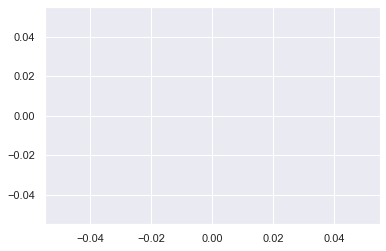

In [673]:
# 862.889001s @ 600s delay
# 1800s delay why does it go down again??

ex_times = np.arange(30000, 35000, 100)
res = []
for time in ex_times:
    res.append(grb.check_if_visible(time*u.s, 30000*u.s, s, mode="difference"))

plt.plot(ex_times, res)

RuntimeError: Unable to parse arguments

# Create gammapy sensitivity class

In [9]:
s = SensitivityGammapy(
    irf=irf20,
    observatory=f"cta_{irf20.site.name}",
    radius=3.0 * u.deg,
    min_energy=0.03 * u.TeV,
    max_energy=10 * u.TeV,
)

sc = SensitivityCtools(
    "/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/alpha_configuration/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
    min_energy=0.03*u.TeV,
    max_energy=10*u.TeV,
)

In [10]:
def get_grb_sens(grb: GRB, s: SensitivityGammapy, times: list[int]):
    indices = []
    amplitudes = []
    s_sens = []
    
    for t in times:
        with suppress_warnings_and_logs(False): 
            ss = s.get(t=t, index=grb.get_spectral_index(t), amplitude=grb.get_spectral_amplitude(t), mode="photon_flux")
            # scs = sc.get(t=t)
            indices.append(grb.index_at(np.log10(t.value)))
            amplitudes.append(grb.amplitude_at(np.log10(t.value)))
            s_sens.append(ss.value)
            # sc_sens.append(scs)
        
    return indices, amplitudes, s_sens

In [11]:
grb_dir = "/Users/jarred/Downloads/TeV Catalog O5"

# get first 100 GRB files with pathlib
grb_files = list(Path(grb_dir).glob("*.fits"))[:100]

res = {}

times = [2**i*u.s for i in range(1, 15)]

sc_sens = []
for t in times:
    scs = sc.get(t=t)
    sc_sens.append(scs)

# pick 10 random files
for g in tqdm(random.sample(grb_files, 10)):
    grb = GRB(g)
    grb_number = int(g.stem.split("_")[1])
    res[grb_number] = get_grb_sens(grb, s, times)
    


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


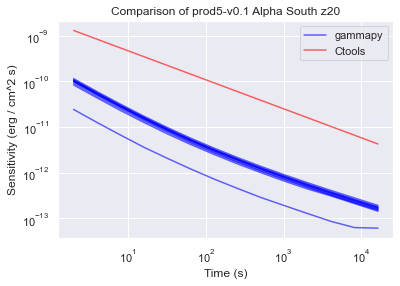

In [39]:
for grb_number, (indices, amplitudes, s_sens) in res.items():
    label = None
    if grb_number == list(res.keys())[0]:
        label = "gammapy"
    plt.loglog([t.value for t in times], s_sens, color="blue", alpha=0.6, label=label)
    # plt.loglog(times, sc_sens, color="red", alpha=0.1)
# plt.loglog(times, np.array(s_sens), label="Gammapy")
plt.loglog([t.value for t in times], [sval.value for sval in sc_sens], color="red", label="Ctools", alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Sensitivity (erg / cm^2 s)")
plt.title("Comparison of prod5-v0.1 Alpha South z20")
plt.legend()


plt.show()

# Comparing with ctools powerlaws

In [32]:
ct = pd.read_csv("integral-models.csv")


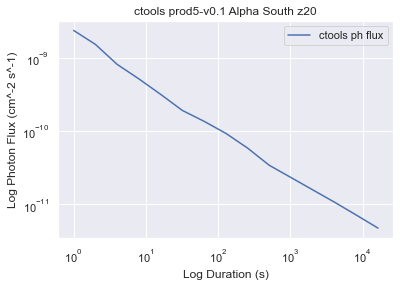

In [42]:
plt.loglog(ct.duration, ct.photon_flux, label="ctools ph flux")
# plt.title("ctools prod5-v0.1 Alpha South z20")
plt.title("ctools prod5-v0.1 Alpha South z20")
plt.ylabel("Log Photon Flux (cm^-2 s^-1)")
plt.xlabel("Log Duration (s)")
plt.legend()
plt.show()

In [18]:
# fit a line to ct.duration, ct.model_prefactor
m, b = np.polyfit(np.log10(ct.duration), np.log10(ct.model_prefactor), 1)


In [20]:
m, b

(-0.5523195343439522, -10.257979663323091)

Text(0.5, 1.0, 'ctools prod5-v0.1 Alpha South z20')

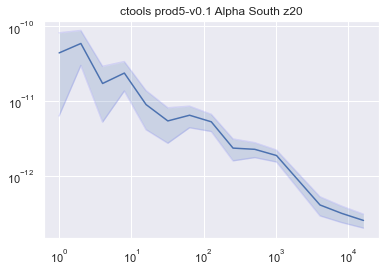

In [15]:
plt.loglog(ct.duration, ct.model_prefactor)
plt.loglog(ct.duration, ct.model_prefactor + ct.model_prefactor_error, alpha=0.1, color="blue")
plt.loglog(ct.duration, ct.model_prefactor - ct.model_prefactor_error, alpha=0.1, color="blue")
plt.fill_between(ct.duration, ct.model_prefactor + ct.model_prefactor_error, ct.model_prefactor - ct.model_prefactor_error, alpha=0.2)
plt.title("ctools prod5-v0.1 Alpha South z20")

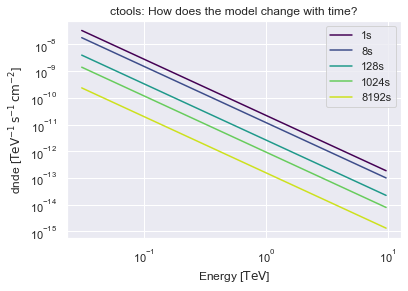

In [33]:

color_scale = plt.cm.viridis(np.linspace(0, 1, len(ct)))

for i, row in enumerate(ct.iterrows()):
    
    if row[1].duration not in [1, 8, 128, 1024, 8192]:
        continue
    
    power_law = PowerLawSpectralModel(
        index=-row[1].model_index,
        amplitude=(row[1].model_prefactor * u.Unit("cm-2 s-1 MeV-1")),
        reference=row[1].model_pivot * u.MeV,
    )
    
    # Plot with rotated colors
    power_law.plot(energy_bounds=[0.03, 10] * u.TeV, label=f"{int(row[1].duration)}s", color=color_scale[i])
    
# plot a few grb models
# for grb_number, (indices, amplitudes, s_sens) in res.items():
#     power_law = PowerLawSpectralModel(
#         index=-indices[5],
#         amplitude=(amplitudes[5] * u.Unit("cm-2 s-1 TeV-1")),
#         reference=1 * u.MeV,
#     )
#     
#     power_law.plot(energy_bounds=[0.03, 10] * u.TeV, color="red", alpha=0.5)
    
plt.title("ctools: How does the model change with time?")
plt.legend()
plt.show()

### Slope -3.1
- checking slope -3.1 for ctools

In [75]:
ct2 = pd.read_csv("integral-models-slope-2.1.csv")
ct3 = pd.read_csv("integral-models-slope-3.1.csv")

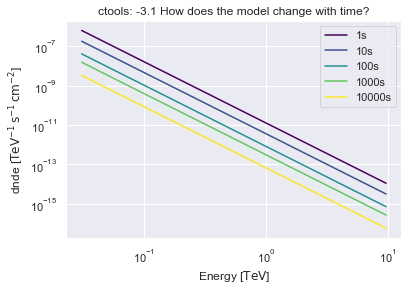

In [72]:
color_scale = plt.cm.viridis(np.linspace(0, 1, len(ct3)))

for i, row in enumerate(ct3.iterrows()):
    power_law = PowerLawSpectralModel(
        index=-row[1].model_index,
        amplitude=(row[1].model_prefactor * u.Unit("cm-2 s-1 MeV-1")),
        reference=row[1].model_pivot * u.MeV,
    )
    
    # Plot with rotated colors
    power_law.plot(energy_bounds=[0.03, 10] * u.TeV, label=f"{int(row[1].duration)}s", color=color_scale[i])
    
# plot a few grb models
# for grb_number, (indices, amplitudes, s_sens) in res.items():
#     power_law = PowerLawSpectralModel(
#         index=-indices[5],
#         amplitude=(amplitudes[5] * u.Unit("cm-2 s-1 TeV-1")),
#         reference=1 * u.MeV,
#     )
#     
#     power_law.plot(energy_bounds=[0.03, 10] * u.TeV, color="red", alpha=0.5)
    
plt.title("ctools: -3.1 How does the model change with time?")
plt.legend()
plt.show()

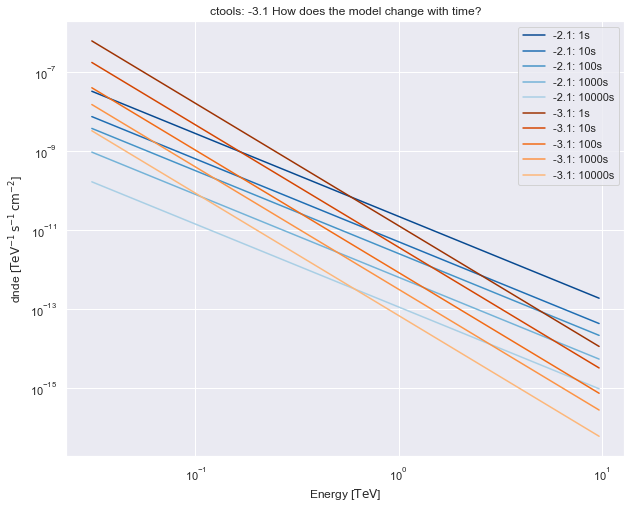

In [76]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

for i, row in enumerate(ct2.iterrows()):
    
    power_law = PowerLawSpectralModel(
        index=-row[1].model_index,
        amplitude=(row[1].model_prefactor * u.Unit("cm-2 s-1 MeV-1")),
        reference=row[1].model_pivot * u.MeV,
    )
    
    # Get a color from the colormap based on the loop index
    color = cm.Blues_r(0.1 + 0.7 * (i / len(ct2)))
    
    # Plot with the color
    power_law.plot(energy_bounds=[0.03, 10] * u.TeV, label=f"-2.1: {int(row[1].duration)}s", color=color)

for i, row in enumerate(ct3.iterrows()):
    power_law = PowerLawSpectralModel(
        index=-row[1].model_index,
        amplitude=(row[1].model_prefactor * u.Unit("cm-2 s-1 MeV-1")),
        reference=row[1].model_pivot * u.MeV,
    )
    
    # Get a color from the colormap based on the loop index
    color = cm.Oranges_r(0.1 + 0.7 * (i / len(ct3)))
    
    # Plot with the color
    power_law.plot(energy_bounds=[0.03, 10] * u.TeV, label=f"-3.1: {int(row[1].duration)}s", color=color)
    
plt.title("ctools: -3.1 How does the model change with time?")
plt.legend()
plt.show()

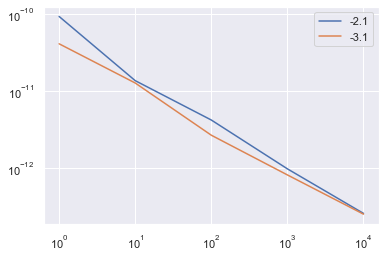

m2: -0.6275456172594213, b2: -10.120670127064868
m3: -0.5632664283464492, b3: -10.383868856184577


In [79]:
plt.loglog(ct2.duration, ct2.sensitivity, label="-2.1")
plt.loglog(ct3.duration, ct3.sensitivity, label="-3.1")
plt.legend()
plt.show()

# fit both lines
m2, b2 = np.polyfit(np.log10(ct2.duration), np.log10(ct2.sensitivity), 1)
m3, b3 = np.polyfit(np.log10(ct3.duration), np.log10(ct3.sensitivity), 1)

print(f"m2: {m2}, b2: {b2}")
print(f"m3: {m3}, b3: {b3}")

In [80]:
ct2[["duration", "model_prefactor"]]

,duration,model_prefactor
0,1,4.415519e-11
1,10,1.006121e-11
2,100,5.046282e-12
3,1000,1.264526e-12
4,10000,2.237842e-13


-0.5523195343439522 -10.257979663323091


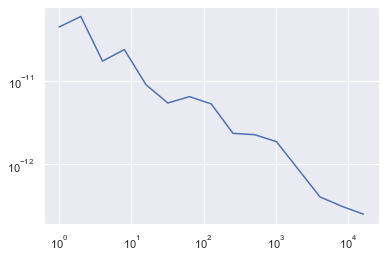

In [70]:
plt.loglog(ct.duration, ct.model_prefactor)

# fit duration and prefactor to a line
m, b = np.polyfit(np.log10(ct.duration), np.log10(ct.model_prefactor), 1)

print(m, b)

In [57]:
ct3[["duration", "model_prefactor"]]

,duration,model_prefactor
0,1,4.415519e-11
1,10,1.006121e-11
2,100,5.046282e-12
3,1000,1.264526e-12
4,10000,2.237842e-13


-0.6275456172594213 -10.120670127064868


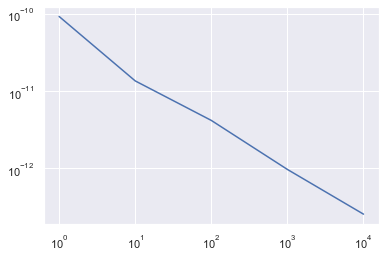

In [68]:
plt.loglog(ct3.duration, ct3.sensitivity)

# fit duration and prefactor to a line
m, b = np.polyfit(np.log10(ct3.duration), np.log10(ct3.sensitivity), 1)

print(m, b)

In [878]:
# calculate sensitivity using gammapy with the same models as ctools
sens = []

for i, row in enumerate(ct.iterrows()):
            
    time_sens = s.get(
        t=row[1].duration * u.s,
        index=-row[1].model_index,
        amplitude=(row[1].model_prefactor * u.Unit("cm-2 s-1 MeV-1")).to("cm-2 s-1 TeV-1"),
        reference=row[1].model_pivot * u.MeV,
        mode="sensitivity",
    ).to("erg / (cm2 s)")
    
    print(row[1].duration, row[1].model_prefactor, time_sens)
    
    
    sens.append(time_sens.value)

1.0 4.41551867787115e-11 7.006191586407862e-14 erg / (s cm2)
2.0 5.9048152580877e-11 3.59190695969787e-14 erg / (s cm2)


4.0 1.72152815829582e-11 1.8691181435831686e-14 erg / (s cm2)
8.0 2.3724105462816398e-11 9.932167913347881e-15 erg / (s cm2)


16.0 8.986302748655729e-12 5.4229758465646034e-15 erg / (s cm2)


32.0 5.43159694723257e-12 3.0574898491418e-15 erg / (s cm2)
64.0 6.473339375409639e-12 1.784397021661562e-15 erg / (s cm2)


128.0 5.28641510885781e-12 1.0775444479716329e-15 erg / (s cm2)
256.0 2.35082342982632e-12 6.714510026000161e-16 erg / (s cm2)


512.0 2.26409721141778e-12 4.300094101248179e-16 erg / (s cm2)
1024.0 1.8698915307681197e-12 2.8176425866926156e-16 erg / (s cm2)


4096.0 4.07701938970433e-13 1.2740432070728354e-16 erg / (s cm2)
8192.0 3.14634408000517e-13 8.728207236117553e-17 erg / (s cm2)


16384.0 2.53062485155118e-13 6.030918359294031e-17 erg / (s cm2)


In [879]:
sens

[7.006191586407862e-14,
 3.59190695969787e-14,
 1.8691181435831686e-14,
 9.932167913347881e-15,
 5.4229758465646034e-15,
 3.0574898491418e-15,
 1.784397021661562e-15,
 1.0775444479716329e-15,
 6.714510026000161e-16,
 4.300094101248179e-16,
 2.8176425866926156e-16,
 1.2740432070728354e-16,
 8.728207236117553e-17,
 6.030918359294031e-17]

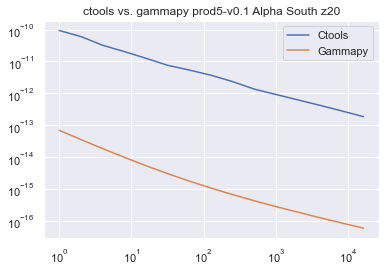

In [880]:
plt.loglog(ct.duration, ct.sensitivity, label="Ctools")
plt.loglog(ct.duration, np.array(sens), label="Gammapy")
# plt.title("ctools prod5-v0.1 Alpha South z20")
plt.title("ctools vs. gammapy prod5-v0.1 Alpha South z20")
plt.legend()
plt.show()

# testing observations


In [856]:
grb = GRB(grb_files[99])

grb.observe(
    sensitivity=s,
    start_time=60*u.s,
    min_energy=get_emin(irf20.zenith.value),
    max_energy=10000 * u.GeV,
)

ValueError: Quantity truthiness is ambiguous, especially for logarithmic units and temperatures. Use explicit comparisons.

In [352]:
grb.observe(
    sensitivity=sc,
    start_time=0,
    min_energy=get_emin(irf20.zenith.value),
    max_energy=10000 * u.GeV,
)

Quantity truthiness is ambiguous, especially for logarithmic units and temperatures. Use explicit comparisons.


{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_1053.fits'),
 'min_energy': None,
 'max_energy': None,
 'seen': 'error',
 'obs_time': -1,
 'start_time': -1,
 'end_time': -1,
 'error_message': 'Quantity truthiness is ambiguous, especially for logarithmic units and temperatures. Use explicit comparisons.',
 'long': 4.494,
 'lat': -0.289,
 'eiso': 1.54e+50,
 'dist': 360000.0,
 'angle': 48.999}